<a href="https://colab.research.google.com/github/caiorodrigueess/Iniciacao-Cientifica/blob/main/Power_Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to the modeling and simulation of Cellular Wireless Communication Systems - Part 2

Aluno: Caio Rodrigues dos Santos\
Universidade Federal do Ceará, Fortaleza, Brasil

## 1. Introdução

Essa é uma continuação da primeira parte do projeto desenvolvido para introduzir o discente ao estudo de gerência de recursos de rádio e qualidade de serviço dos usuários, tendo como base o material 'Introduction to the modeling and simulation of Cellular Wireless Communication Systems - Part 2' disponibilizado pelo professor orientador.


No primeiro momento, foram introduzidos novos Indicadores Chave de Desempenho (KPIs), como a soma da capacidade, eficiência do espectro e taxa de interrupção. Além disso, foi apresentado um novo modelo de canal que inclui o *shadowing effect* - ou efeito de sombreamento, que reflete as flutuações
aleatórias do sinal devido ao ambiente físico.

## 2. Objetivos

Aprofundar os estudos sobre Comunicações Móveis, além de analisar novos indicadores de desempenho e técnicas de Gerência de Recursos Rádio, incluindo alocação de canais, agregação e controle de potência, bem como estratégias de handover para usuários móveis. O propósito é avaliar a Qualidade do Serviço e
oferecer melhorias de desempenho sem custos adicionais de infraestrutura.

## 3. Resumo das Atividades e Conceitos Absorvidos

A configuração base do sistema continua a mesma para alguns aspectos, mas foram definidos números fixos de UEs e APs:


*   **Área de cobertura:** 1km²;
*   **QoS:** 100 Mbps no 10th percentil da capacidade do canal;
*   **Número de UEs:** K = 13;
*   **Número de APs:** M = 64.

### 3.1. Novos Indicadores de Desempenho

Foram introduzidos novos KPIs que permitem uma avaliação mais completa e eficiente do sistema:


*   **Capacidade de soma (Sum-Capacity):** Representa a taxa total do sistema, somando a capacidade de todos os UEs em ”uma rodada” de simulação.
*   **Eficiência espectral de área (Area Spectrum Efficiency - ASE):** Mede a eficiência da rede, normalizando a capacidade de soma média pela largura de banda total e pela área de cobertura (km²).
*   **Eficiência energética (Energy Efficiency):** Avaliação da energia necessária para transmitir um bit de dados, medida em bits/Joule. Pode ser relacionada com a duração da bateria de um UE.
*   **Taxa de interrupção (Outage rate):** Define a qualidade do serviço mínima que um sistema deve ter. Nesse programa, buscamos 25 Mbps no 5th percentil.

### 3.2. Modelo de canal com shadowing

Na primeira parte, consideramos a distância AP-UE como o fator definitivo para o path gain. Agora, adicionamos uma variável aleatória lognormal em cada enlace de rádio entre um UE e um AP. Dessa forma, as flutuações aleatórias do ambiente físico são adicionadas aos cálculos, tornando a simulação mais fiel à realidade.

## 4. Exercícios

### Exercício 8 (Power Control)

Average sum capacity without power control: 4460.21 Mbps
10th percentile of sinr without power control: -9.41 dB
50th percentile of sinr without power control: 5.17 dB
10th percentile of channel capacity without power control: 15.65 Mbps
50th percentile of channel capacity without power control: 210.12 Mbps

Average sum capacity with power control: 1137.74 Mbps
10th percentile of sinr with power control: -4.27 dB
50th percentile of sinr with power control: -1.09 dB
10th percentile of channel capacity with power control: 45.89 Mbps
50th percentile of channel capacity with power control: 82.98 Mbps



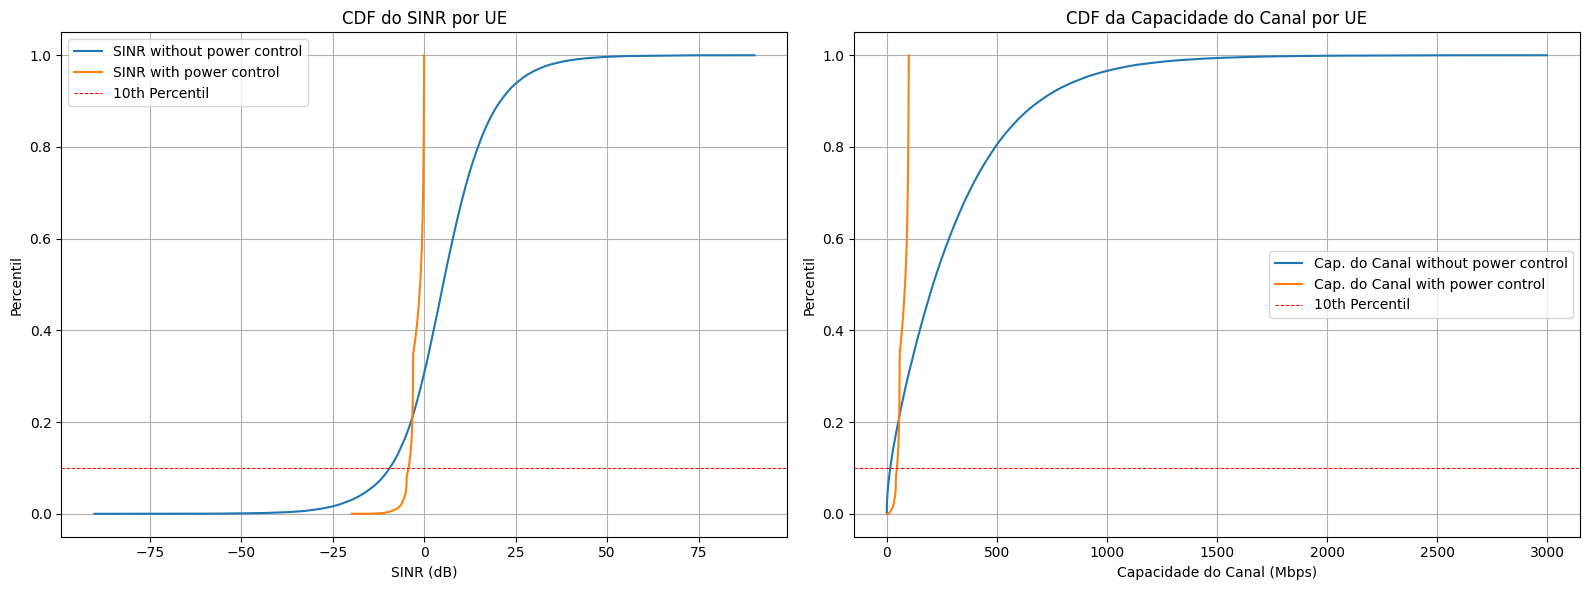

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt

class AP:
    def __init__(self, x: float, y: float, id: int):
        self.x = x
        self.y = y
        self.id = id
        self.channel = None
        self.ues = []

    def __str__(self):
        return f'AP[{self.id}]({self.x}, {self.y})'

class UE:
    id_counter = 0
    def __init__(self):
        self.id = UE.id_counter
        UE.id_counter += 1
        self.x = np.random.randint(0, 1001)
        self.y = np.random.randint(0, 1001)
        self.ap = None
        self.channel = 0
        self.dist = 0
        self.gain = 0
        self.ca = False
        self.sinr = 0
        self.pt = 1

    def __str__(self):
        return f'UE({self.x}, {self.y})'

    def __eq__(self, other):
        if isinstance(other, UE):
            return self.id == other.id
        return False

def distribuir_AP(M: int) -> list:
    APs = []
    dx = 1000/(2*np.sqrt(M))
    a = np.arange(dx, 1001-dx, 2*dx)
    x, y = np.meshgrid(a, a)
    id = 0
    for xi, yi in zip(x.ravel(), y.ravel()):
        APs.append(AP(xi, yi, id))
        id += 1
    return APs

def gain_matrix(ues: list, aps: list) -> np.ndarray:
    ''' Inicializa a matriz'''
    G = np.zeros((len(ues), len(aps)))
    ap_coords = np.array([[ap.x, ap.y] for ap in aps])

    for i, ue in enumerate(ues):
        # garante que o UE não está a menos de 1 m de nenhum AP
        while True:
            ue_coord = np.array([ue.x, ue.y])
            d_all = np.linalg.norm(ap_coords - ue_coord, axis=1)
            if np.all(d_all >= 1):
                break
            ue.x = np.random.randint(0, 1001)
            ue.y = np.random.randint(0, 1001)

        # calcula ganhos para todos APs
        for j, ap in enumerate(aps):
            d_ij = np.linalg.norm(ue_coord - ap_coords[j])
            d = max(d_ij, 1.0)
            G[i, j] = np.random.lognormal(0, 2) * 1e-4 / (d**4)

    return G

def attach_ues_to_aps(ues: list, aps: list, G: np.ndarray) -> None:
    for i, ue in enumerate(ues):
        best_index = np.argmax(G[i, :])   # AP com maior ganho
        ue.ap = aps[best_index]
        ue.gain = G[i, best_index]       # ganho fixo do link desejado
        aps[best_index].ues.append(ue)

    return None

def SINR(ues: list, aps: list, G: np.ndarray, p_vec: np.ndarray, pn: float) -> np.ndarray:
    sinr = np.zeros(len(ues))        # Inicializa o vetor de SINRs

    # Calcula o SINR para cada UE
    for i, ue in enumerate(ues):      # Itera sobre todos os UEs
        ap_index = ue.ap.id           # Busca o indice de qual AP o UE está conectado
        pr = G[i, ap_index] * p_vec[i]    # Calcula a potencia recebida por meio da matriz de ganhos e o vetor de potências

        # Caclcula a soma do pr de todos os UEs interferentes
        interf = np.sum([G[j, ap_index] * p_vec[j] for j in range(len(ues)) if j != i])

        # Armazena os valores de SINR
        sinr[i] = pr / (pn + interf)
        ue.sinr = sinr[i]

    return sinr

def channel_capacity(ue: UE, N: int) -> float:
    bt=100      # 100 MHz de largura de banda
    return np.around((bt/N)*np.log2(1+ue.sinr), 4)

def simular_experimento(M: int, N: int, sim: int, pc: bool = True) -> tuple:
    aps = distribuir_AP(M)  # Mantém a lista fixa de APs
    sinr = []
    cap_canal = []
    ues = []
    av_sum_cap = []

    # Parâmetros
    bt = 1e8
    k0 = 1e-20
    pn = k0 * bt / N
    pt_max = 1.0

    for _ in range(sim):
        ues = [UE() for i in range(15)] # Create UEs as a list

        G = gain_matrix(ues, aps)     # Calcula a matriz de ganhos
        attach_ues_to_aps(ues, aps, G)

        # Potências
        if pc:
            # Channel inversion (SNR alvo = 1)
            pt = np.array([min(pn/ue.gain, pt_max) for ue in ues])
        else:
            pt = np.full(len(ues), pt_max)

        # SINR e capacidades
        s = SINR(ues, aps, G, pt, pn)
        caps = [channel_capacity(ue, N) for ue in ues]

        sinr.extend(x for x in s)
        cap_canal.extend(caps)
        av_sum_cap.append(np.sum(caps))

        for ap in aps:
            ap.ues = []  # Limpa a lista de UEs para o próximo experimento

    return sinr, cap_canal, np.mean(av_sum_cap)

def plot_cdfs(cdf_sinr: list, cdf_capacity: list) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot SINR CDF
    for i in range(len(cdf_sinr)):
        cdf_sinr[i] = [10*np.log10(a) for a in cdf_sinr[i]]
        cdf_sinr[i].sort()
        percentis = np.linspace(0, 1, len(cdf_sinr[i]))
        axes[0].plot(cdf_sinr[i], percentis, label=f'SINR {"with" if i==1 else "without"} power control')

    axes[0].axhline(y=0.10, color='r', linewidth=0.7, linestyle='--', label = f'10th Percentil')
    axes[0].set_title('CDF do SINR por UE')
    axes[0].set_xlabel('SINR (dB)')
    axes[0].set_ylabel('Percentil')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Capacity CDF
    for i in range(len(cdf_capacity)):
        cdf_capacity[i].sort()
        percentis = np.linspace(0, 1, len(cdf_capacity[i]))
        axes[1].plot(cdf_capacity[i], percentis, label=f'Cap. do Canal {"with" if i==1 else "without"} power control')

    axes[1].axhline(y=0.10, color='r', linewidth=0.7, linestyle='--', label = f'10th Percentil')
    axes[1].set_title('CDF da Capacidade do Canal por UE')
    axes[1].set_xlabel('Capacidade do Canal (Mbps)')
    axes[1].set_ylabel('Percentil')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    M = 36
    N = 1
    sim = 10000

    sinr1, cap_canal1, av_sum_cap1 = simular_experimento(M, N, sim, pc=False)
    print(f'Average sum capacity without power control: {av_sum_cap1:.2f} Mbps')
    print(f'10th percentile of sinr without power control: {np.percentile(10*np.log10(sinr1), 10):.2f} dB')
    print(f'50th percentile of sinr without power control: {np.percentile(10*np.log10(sinr1), 50):.2f} dB')
    print(f'10th percentile of channel capacity without power control: {np.percentile(cap_canal1, 10):.2f} Mbps')
    print(f'50th percentile of channel capacity without power control: {np.percentile(cap_canal1, 50):.2f} Mbps\n')

    sinr2, cap_canal2, av_sum_cap2 = simular_experimento(M, N, sim, pc=True)
    print(f'Average sum capacity with power control: {av_sum_cap2:.2f} Mbps')
    print(f'10th percentile of sinr with power control: {np.percentile(10*np.log10(sinr2), 10):.2f} dB')
    print(f'50th percentile of sinr with power control: {np.percentile(10*np.log10(sinr2), 50):.2f} dB')
    print(f'10th percentile of channel capacity with power control: {np.percentile(cap_canal2, 10):.2f} Mbps')
    print(f'50th percentile of channel capacity with power control: {np.percentile(cap_canal2, 50):.2f} Mbps\n')

    plot_cdfs([sinr1, sinr2], [cap_canal1, cap_canal2])

### Exercício 9


### **Item a)**   
SINR: $\gamma_t=0.5 $
<br>
<br>
Temos que $p = (I-A)^{-1}  b$. Assim,
<br>
<br>
$
A =
\begin{bmatrix}
0 & \gamma_t \frac{g_1}{g_2}\\
\gamma_t \frac{g_2}{g_1} & 0
\end{bmatrix}
=
\begin{bmatrix}
0 & 0.5 \frac{0.1}{0.05}\\
0.5 \frac{0.05}{0.1} & 0
\end{bmatrix}
=
\begin{bmatrix}
0 & 1\\
0.25 & 0
\end{bmatrix}
$
,
<br>
<br>
$
b =
\begin{bmatrix}
\gamma_t \frac{p_n}{g_1}\\
\gamma_t \frac{p_n}{g_2}
\end{bmatrix}
=
\begin{bmatrix}
0.5\\
0.1
\end{bmatrix}
$
,
<br>
<br>
$
I - A =
\begin{bmatrix}
1-0 & 0-1\\
0-0.25 & 1-0
\end{bmatrix}
=
\begin{bmatrix}
1 & -1\\
-0.25 & 1
\end{bmatrix}
$
,
<br>
<br>
$
(I-A)^{-1} = \frac{1}{0.75}
\begin{bmatrix}
1 & 1\\
0.25 & 1
\end{bmatrix}
=
\begin{bmatrix}
\frac{1}{0.75} & \frac{1}{0.75}\\
\frac{0.25}{0.75} & \frac{1}{0.75}
\end{bmatrix}
$
,
<br>
<br>
Então, o vetor da potência é dado por
<br>
<br>
$
p =
\begin{bmatrix}
\frac{1}{0.75} & \frac{1}{0.75}\\
\frac{0.25}{0.75} & \frac{1}{0.75}
\end{bmatrix}
\begin{bmatrix}
0.5\\
0.1
\end{bmatrix}
=
\begin{bmatrix}
0.2\\
0.15
\end{bmatrix}
$

### **Item b)**

SINR: $\gamma_t=2$
<br>
<br>
$
A =
\begin{bmatrix}
0 & 4\\
1 & 0
\end{bmatrix}
$
,
<br>
<br>
$b =
\begin{bmatrix}
0.2\\
0.4
\end{bmatrix}
$
,
<br>
<br>
$
I - A =
\begin{bmatrix}
1 & -4\\
-1 & 1
\end{bmatrix}
$
,
<br>
<br>
$
(I-A)^{-1} = \frac{-1}{3}
\begin{bmatrix}
1 & 4\\
1 & 1
\end{bmatrix}
=
\begin{bmatrix}
\frac{-1}{3} & \frac{-4}{3}\\
\frac{-1}{3} & \frac{-1}{3}\\
\end{bmatrix}
$
,
<br>
<br>
Então, o vetor da potência é dado por
<br>
<br>
$
p =
\begin{bmatrix}
\frac{-1}{3} & \frac{-4}{3}\\
\frac{-1}{3} & \frac{-1}{3}\\
\end{bmatrix}
\begin{bmatrix}
0.2\\
0.4
\end{bmatrix}
=
\begin{bmatrix}
-0.6\\
-0.2
\end{bmatrix}
$


Notamos que a potência obtida é negativa, que não é um conceito físico existente. Logo, concluimos que não é possível encontrar a potência para esse dado SINR.

### **Item c)**

SINR: $\gamma_t=1$
<br>
<br>
$
A =
\begin{bmatrix}
0 & 2\\
0.5 & 0
\end{bmatrix}
$
,
<br>
<br>
$
I - A =
\begin{bmatrix}
1 & -2\\
-0.5 & 1
\end{bmatrix}
$
,
<br>
<br>
$
det(I-A) =
\begin{vmatrix}
1 & -2\\
-0.5 & 1
\end{vmatrix}
=
1-1=0
$
<br>
<br>

A matriz não é invertível.